In [1]:
import numpy as np
import pandas as pd
import re
from scipy.stats import chi2_contingency
from scipy import stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns
sns.set_theme(style="darkgrid")

import matplotlib.pyplot as plt
%matplotlib inline

___
### Data
___

In [3]:
df = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

In [4]:
# Shuffle the data
df = df.sample(n=len(df), random_state=1)

In [5]:
df.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
2073,2221_01,Earth,True,G/355/P,PSO J318.5-22,29.0,False,0.0,0.0,0.0,0.0,0.0,Andrey Fisherry,True
1190,1263_01,Mars,False,F/244/S,TRAPPIST-1e,25.0,False,1084.0,1.0,66.0,0.0,5.0,Batses Vloaf,False
211,0222_02,Mars,True,F/41/S,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,0.0,0.0,Colf Deva,True
1686,1792_01,Mars,False,F/352/P,TRAPPIST-1e,73.0,False,27.0,2.0,71.0,1208.0,0.0,Duckes Brazo,False
908,0982_02,Earth,False,G/145/P,TRAPPIST-1e,51.0,False,NaN,NaN,4.0,0.0,0.0,Joyton Hewson,False


In [6]:
df.shape

(8693, 14)

In [7]:
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

Since there are quite a few True/False values in the data, I'll convert them binary

True = 1, False = 0

In [8]:
df = df.replace({True: 1, False: 0})

df[['CryoSleep', 'VIP', 'Transported']] = df[['CryoSleep', 'VIP', 'Transported']].astype(pd.Int64Dtype())

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CryoSleep,8476.0,0.358306,0.479531,0.0,0.0,0.0,1.0,1.0
Age,8514.0,28.82793,14.489021,0.0,19.0,27.0,38.0,79.0
VIP,8490.0,0.023439,0.151303,0.0,0.0,0.0,0.0,1.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.48924,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0
Transported,8693.0,0.503624,0.500016,0.0,0.0,1.0,1.0,1.0


In [10]:
df.shape

(8693, 14)

In [11]:
df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [12]:
df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

___
#### Split "PassengerID" column
___
 The ID format is *gggg_pp*, where *gggg* is the group the passenger is traveling with, and *pp* is their number within the group.
 
 People in the same group are often family members, but not always. 


In [13]:
df["PassengerId"].sample(5)

3144    3392_02
5216    5561_04
3507    3769_01
3037    3284_01
8177    8736_02
Name: PassengerId, dtype: object

Check if each column has the same length, and a underscore in the same position to find out if the format is consistent for all of the data.

In [14]:
df['PassengerId'].apply(len).nunique() == 1

True

In [15]:
all_underscore = df["PassengerId"].str[-3] == '_'
all_underscore.all()

True

In [16]:
df["PassengerGroup"] = df["PassengerId"].str[:4]
df["PassengerNumberInGroup"] = df["PassengerId"].str[-2:]

In [17]:
df.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup,PassengerNumberInGroup
2105,2257_01,Europa,0,C/76/P,TRAPPIST-1e,27.0,1,0.0,3341.0,NaN,80.0,654.0,Atonea Diateous,1,2257,01
2719,2913_01,Mars,0,F/603/P,TRAPPIST-1e,49.0,0,21.0,25.0,1509.0,0.0,1042.0,Pefox Sau,0,2913,01
626,0653_01,Mars,<NA>,E/45/S,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Rionk Paska,1,0653,01
5099,5447_02,Mars,<NA>,F/1126/P,TRAPPIST-1e,36.0,0,0.0,0.0,0.0,0.0,0.0,Poselk Coune,1,5447,02
8459,9034_03,Europa,0,D/288/P,55 Cancri e,27.0,0,0.0,984.0,0.0,13995.0,312.0,Phecca Headmish,0,9034,03


In [18]:
# Convert to integers
df['PassengerNumberInGroup'] = pd.to_numeric(df['PassengerNumberInGroup'], errors='coerce').astype('Int64')
df['PassengerGroup'] = pd.to_numeric(df['PassengerGroup'], errors='coerce').astype('Int64')

In [19]:
number_of_groups = df['PassengerGroup'].nunique()

# Count passengers in each group
group_sizes = df.groupby('PassengerGroup').size()

# Find the group with the largest number of passengers and its size
largest_group = group_sizes.idxmax()  # Group with the most passengers
largest_group_size = group_sizes.max()  # Number of passengers in the largest group

print(f"Largest group: {largest_group} with {largest_group_size} passengers")
print(f"Number of groups: {number_of_groups}")


Largest group: 984 with 8 passengers
Number of groups: 6217


*Notes:*
- There are 6217 unique groups in the data.
- The largest group has 8 passengers in it. 

___
#### Split "Cabin" column
___

The cabin numbers is formatted as deck/number/side. Side can be either P for Port or S for Starboard.

I'll split these up into three separate columns.

In [20]:
df["Deck"] = df["Cabin"].str[0]
df["ShipSide"] = df["Cabin"].str[-1:]

# Extract the middle value between slashes in the 'Cabin' column to get the cabin number
df['CabinNumber'] = df['Cabin'].str.extract(r'/(?P<middle>[^/]+)/')['middle']

In [21]:
number_of_cabins = df['CabinNumber'].nunique()
avg_passenger_per_cabin = round(len(df) / number_of_cabins, 1)
print(f"Total cabins: {number_of_cabins}\nAvg. Passengers per cabin: {avg_passenger_per_cabin}")


# Group by 'CabinNumber' and count the number of passengers in each cabin
cabin_counts = df.groupby('CabinNumber').size()

# Filter for cabins with only one passenger and count them
single_passenger_cabins = (cabin_counts == 1).sum()
double_passenger_cabins = (cabin_counts == 2).sum()

# Calculate percentages
single_passenger_percentage = (single_passenger_cabins / len(df)) * 100
double_passenger_cabins_percentage = (double_passenger_cabins / len(df)) * 100



print(f"Number of cabins with only one passenger: {single_passenger_cabins} ({single_passenger_percentage:.1f}%)")
print(f"Number of cabins with two passengers: {double_passenger_cabins} ({double_passenger_cabins_percentage:.1f}%)")

# Find largest cabin
largest_cabin = (cabin_counts).max()
print("Largest cabin: ", largest_cabin)

Total cabins: 1817
Avg. Passengers per cabin: 4.8
Number of cabins with only one passenger: 268 (3.1%)
Number of cabins with two passengers: 370 (4.3%)
Largest cabin:  28


*Notes:*
- The cabins are quite large, and the average number of passengers per cabin is 4.8.
- 268 passengers has their own cabin, only 3.1%.
- 370 passengers share cabins with only one person, only 4.3%.
- The largest cabin has 28 passengers in it, so it's some kind of dorm probably.

___
### Quick Stats
___

#### Transported

In [22]:
counts = df["Transported"].value_counts(dropna=False)
percentages = df["Transported"].value_counts(normalize=True, dropna=False) * 100
transported_summary = pd.DataFrame({"Count": counts, "Percentage": percentages.round(1)})
transported_summary

,Count,Percentage
Transported,,
1,4378,50.4
0,4315,49.6


#### Transported by HomePlanet

In [23]:
# Get counts and percentages
counts = df["HomePlanet"].value_counts(dropna=False)
percentages = df["HomePlanet"].value_counts(normalize=True, dropna=False) * 100

home_planet_summary = pd.DataFrame({"Count": counts, "Percentage": percentages.round(1)})
home_planet_summary

,Count,Percentage
HomePlanet,,
Earth,4602,52.9
Europa,2131,24.5
Mars,1759,20.2
NaN,201,2.3


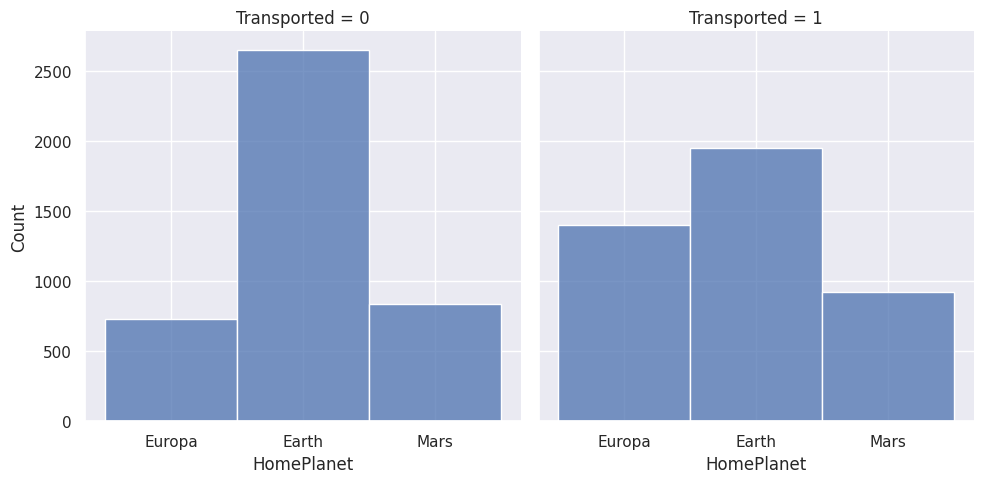

In [24]:
sns.displot(df, x='HomePlanet', col='Transported', binwidth=10, height=5)

#### Transported by Destination

In [25]:
# Get counts and percentages
counts = df["Destination"].value_counts(dropna=False)
percentages = df["Destination"].value_counts(normalize=True, dropna=False) * 100

destination_summary = pd.DataFrame({"Count": counts, "Percentage": percentages.round(1)})
destination_summary

,Count,Percentage
Destination,,
TRAPPIST-1e,5915,68.0
55 Cancri e,1800,20.7
PSO J318.5-22,796,9.2
NaN,182,2.1


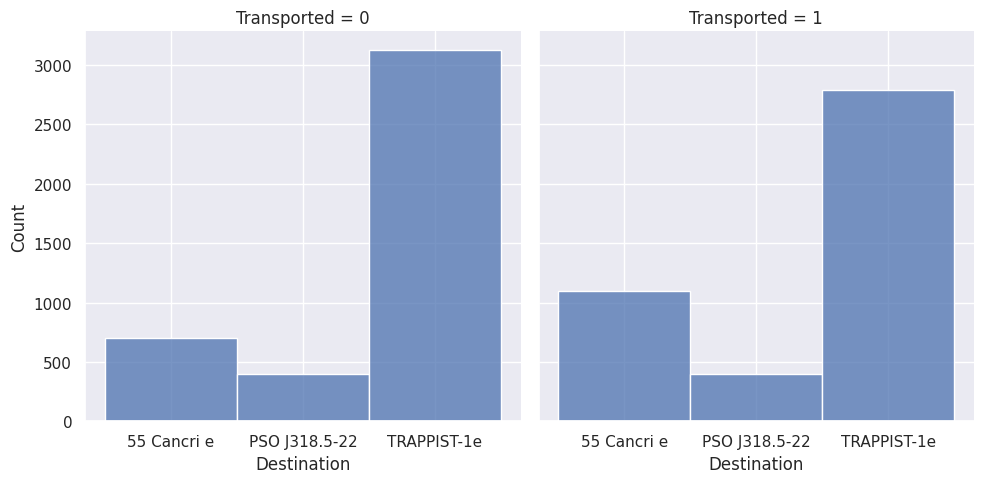

In [26]:
sns.displot(df, x='Destination', col='Transported', binwidth=10, height=5)

#### Transported by CryoSleep

In [27]:
# Get counts and percentages
counts = df["CryoSleep"].value_counts(dropna=False)
percentages = df["CryoSleep"].value_counts(normalize=True, dropna=False) * 100

cryosleep_summary = pd.DataFrame({"Count": counts, "Percentage": percentages.round(1)})
cryosleep_summary

,Count,Percentage
CryoSleep,,
0,5439,62.6
1,3037,34.9
<NA>,217,2.5


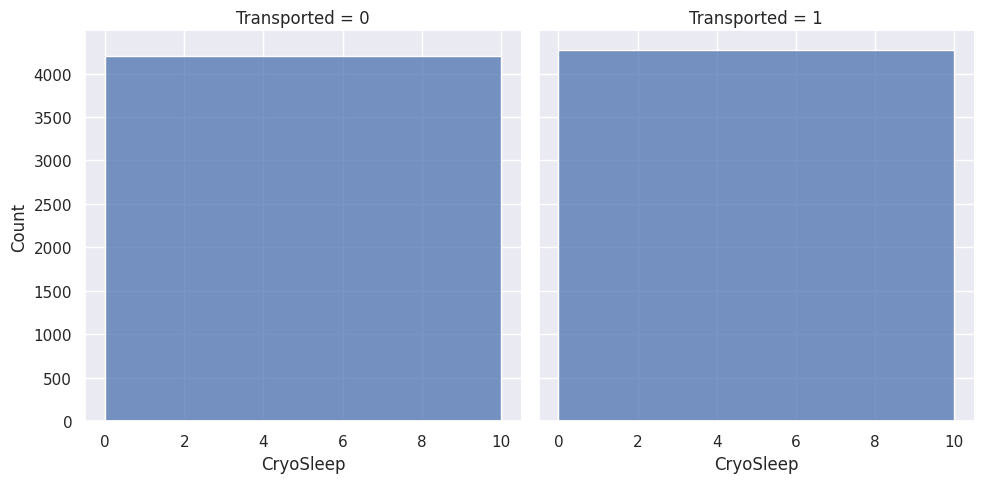

In [28]:
sns.displot(df, x='CryoSleep', col='Transported', binwidth=10, height=5)

#### Transported by Age

There is a large range of ages, so it probably makes sense to group them to get a better overview. 

In [29]:
# Bins and labels
age_bins = [-1, 9, 19, 29, 39, 49, 59, 69, float("inf")]
age_labels = ["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70+"]

# Categorize the "Age" column into these custom bins
df["AgeGroup"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels, right=True)

In [30]:
# Get counts and percentages
counts = df["AgeGroup"].value_counts(dropna=False)
percentages = df["AgeGroup"].value_counts(normalize=True, dropna=False) * 100

age_group_summary = pd.DataFrame({"Count": counts, "Percentage": percentages.round(1)})
age_group_summary

,Count,Percentage
AgeGroup,,
20-29,2762,31.8
30-39,1735,20.0
10-19,1479,17.0
40-49,1048,12.1
0-9,679,7.8
50-59,557,6.4
60-69,208,2.4
NaN,179,2.1
70+,46,0.5


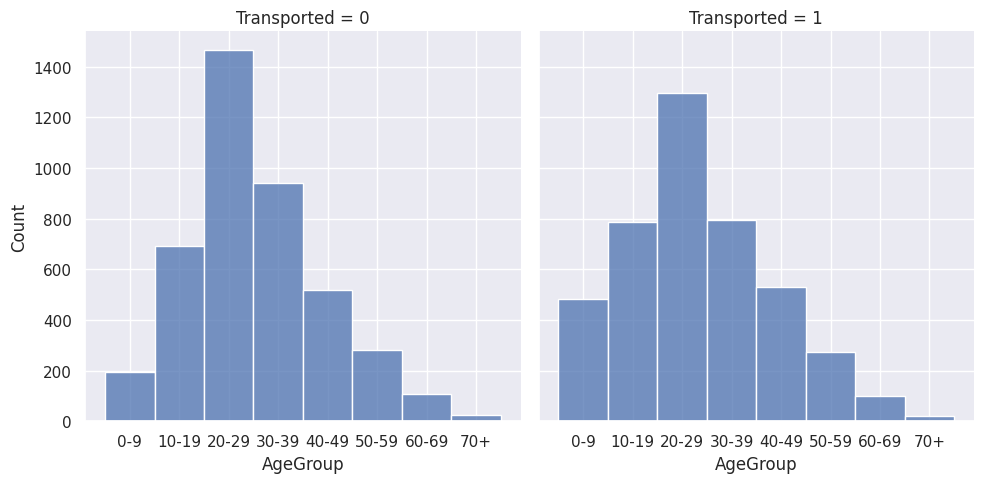

In [31]:
sns.displot(df, x="AgeGroup", col="Transported", binwidth=8, height=5)

#### Transported by ShipSide

In [32]:
# Get counts and percentages
counts = df["ShipSide"].value_counts(dropna=False)
percentages = df["ShipSide"].value_counts(normalize=True, dropna=False) * 100

ship_side_summary = pd.DataFrame({"Count": counts, "Percentage": percentages.round(1)})
ship_side_summary

,Count,Percentage
ShipSide,,
S,4288,49.3
P,4206,48.4
NaN,199,2.3


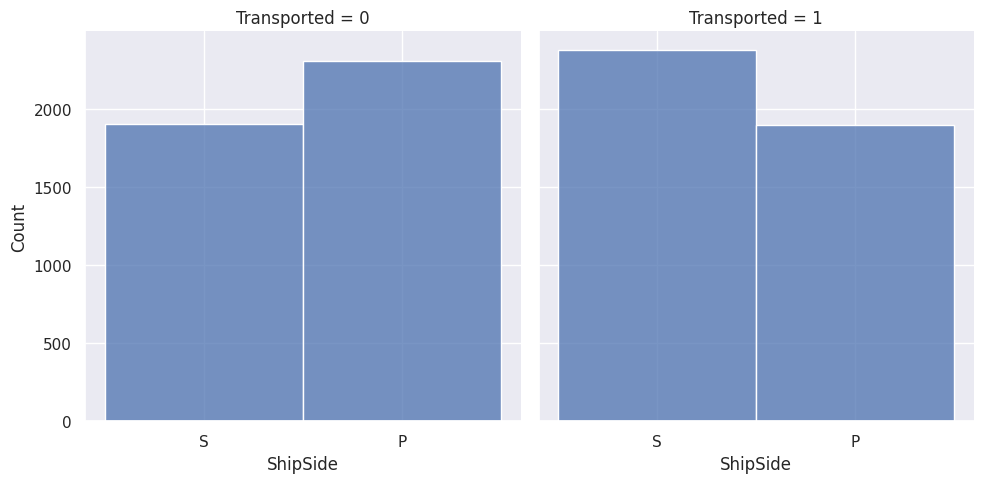

In [33]:
sns.displot(df, x="ShipSide", col="Transported", binwidth=8, height=5)

#### Transported by Deck 

In [34]:
# Get counts and percentages
counts = df["Deck"].value_counts(dropna=False)
percentages = df["Deck"].value_counts(normalize=True, dropna=False) * 100

deck_summary = pd.DataFrame({"Count": counts, "Percentage": percentages.round(1)})
deck_summary

,Count,Percentage
Deck,,
F,2794,32.1
G,2559,29.4
E,876,10.1
B,779,9.0
C,747,8.6
D,478,5.5
A,256,2.9
NaN,199,2.3
T,5,0.1


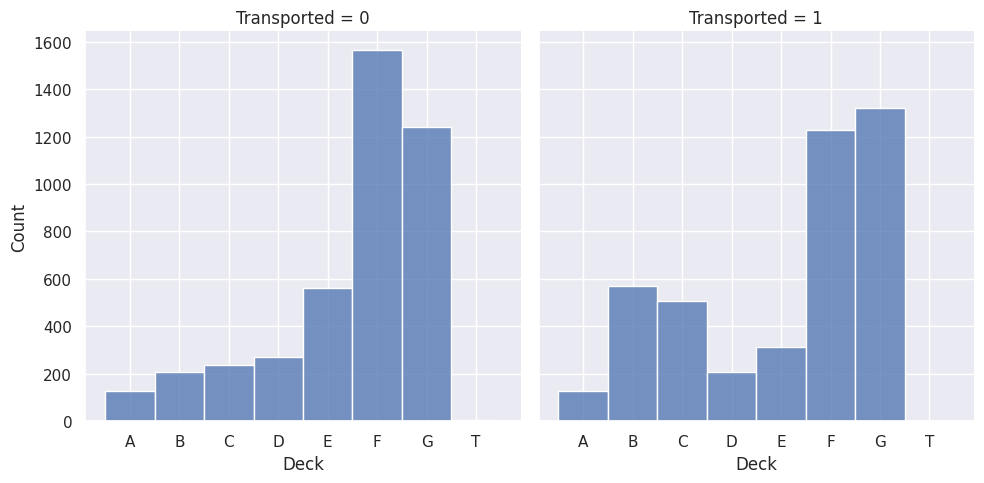

In [35]:
deck_order = ["A", "B", "C", "D", "E", "F", "G", "T"]
df["Deck"] = pd.Categorical(df["Deck"], categories=deck_order, ordered=True)
sns.displot(df, x="Deck", col="Transported", binwidth=8, height=5)

#### Transported by GroupSize

In [36]:
# Group
df["GroupSize"] = df.groupby("PassengerGroup")["PassengerGroup"].transform("size")
# Get counts and percentages
counts = df["GroupSize"].value_counts(dropna=False)
percentages = df["GroupSize"].value_counts(normalize=True, dropna=False) * 100

group_size_summary = pd.DataFrame({"Count": counts, "Percentage": percentages.round(1)})
group_size_summary

,Count,Percentage
GroupSize,,
1,4805,55.3
2,1682,19.3
3,1020,11.7
4,412,4.7
5,265,3.0
7,231,2.7
6,174,2.0
8,104,1.2


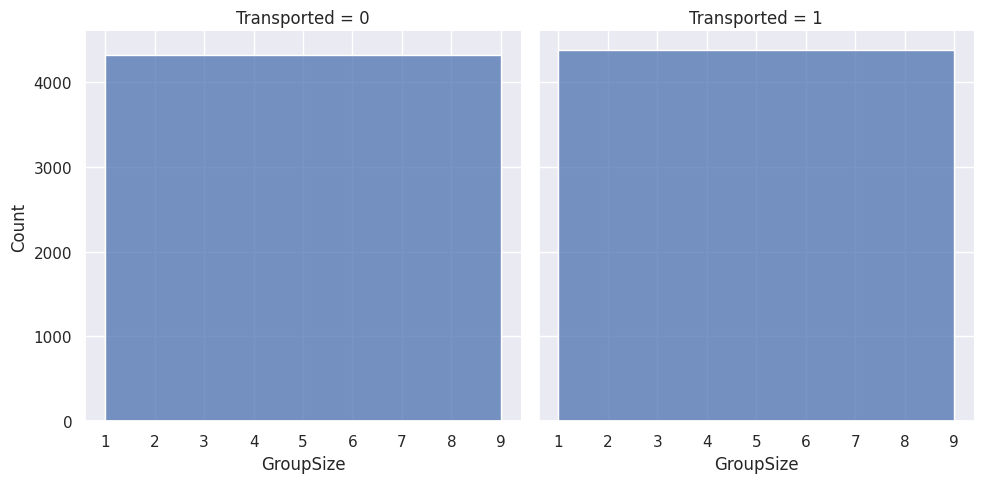

In [37]:
sns.displot(df, x="GroupSize", col="Transported", binwidth=8, height=5)

#### Transported by VIP

In [38]:
# Get counts and percentages
counts = df["VIP"].value_counts(dropna=False)
percentages = df["VIP"].value_counts(normalize=True, dropna=False) * 100

vip_summary = pd.DataFrame({"Count": counts, "Percentage": percentages.round(1)})
vip_summary

,Count,Percentage
VIP,,
0,8291,95.4
<NA>,203,2.3
1,199,2.3


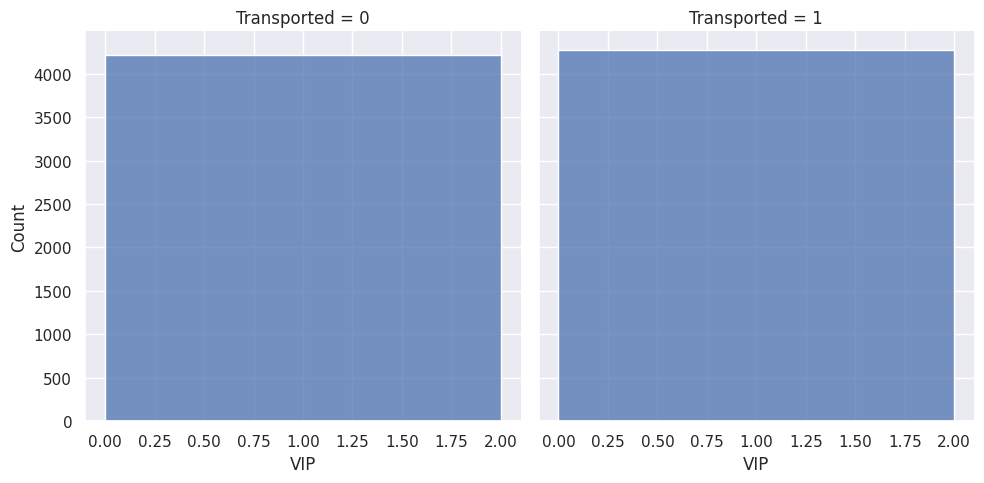

In [39]:
sns.displot(df, x="VIP", col="Transported", binwidth=2, height=5)

#### Transported by TotalMoneySpent


In [40]:
df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'PassengerGroup', 'PassengerNumberInGroup',
       'Deck', 'ShipSide', 'CabinNumber', 'AgeGroup', 'GroupSize'],
      dtype='object')

In [41]:
money_columns = ["Spa", "ShoppingMall", "FoodCourt", "VRDeck", "RoomService"]
df[money_columns] = df[money_columns].fillna(0)

In [42]:
# Calculate TotalMoneySpent
df["TotalMoneySpent"] = df["ShoppingMall"] + df["RoomService"] + df["FoodCourt"] + df["Spa"] + df["VRDeck"]

# Bins and labels
spending_bins = [-0.001, 1000, 3000, 5000, float("inf")]
spending_labels = ["0-1000", "1001-3000", "3001-5000", "5000+"]
df["SpendingCategory"] = pd.cut(df["TotalMoneySpent"], bins=spending_bins, labels=spending_labels, right=True)

# Get counts and percentages for each SpendingCategory
counts = df["SpendingCategory"].value_counts(dropna=False)
percentages = df["SpendingCategory"].value_counts(normalize=True, dropna=False) * 100


mean_money_spent = df["TotalMoneySpent"].mean()
print("Mean money spent: ", mean_money_spent)

# Create summary DataFrame
money_spent_summary = pd.DataFrame({"Count": counts, "Percentage": percentages.round(1)})
money_spent_summary


Mean money spent:  1440.8663292304152


,Count,Percentage
SpendingCategory,,
0-1000,5860,67.4
1001-3000,1717,19.8
5000+,637,7.3
3001-5000,479,5.5


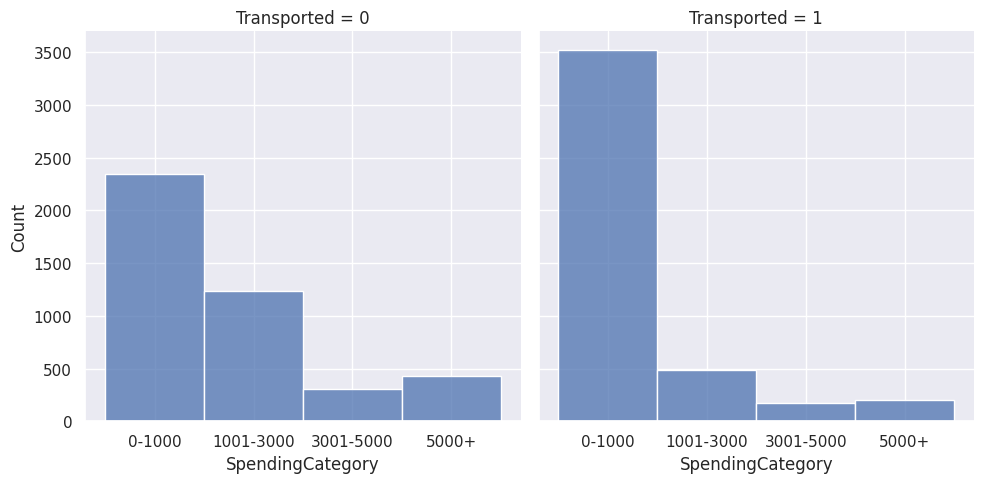

In [43]:
sns.displot(df, x="SpendingCategory", col="Transported", binwidth=7, height=5)

### Notes:

- Transported: 50.4% of passengers were transported, making it almost an even split.

- HomePlanet: Passengers from Earth had a transportation rate above 50%.

- Destination: Passengers headed to TRAPPIST-1e had a 68% transport rate, while those going to 55 Cancri e and PSO J318.5-22 had much lower rates at 20.7% and 9.2%, respectively.

- CryoSleep: Passengers not in cryo-sleep had a 62.6% transport rate, while those in cryo-sleep had a significantly lower rate of 34.9%.

- Age: Teenagers and young adults, especially those in their twenties, had the highest transportation rate (31.8%), while very young and older passengers had lower rates.

- ShipSide: Transport rates were nearly identical for both sides of the ship, suggesting it had little impact.

- Deck: Passengers on decks F and G had much higher transport rates than those on other decks.

- Group Size: Solo travelers had a 55% transport rate, with transport likelihood decreasing as group size increased.

- VIP: Only 2% of passengers had VIP status, so it offers little insight into transport likelihood.

- Money Spent: Most passengers (59.5%) spent under $1000. Spending did not appear to correlate with transportation outcomes.


___
## Missing Values
___

I'll review each column and try to replace the missing values in the best way possible. 

In [44]:
# Columns with missing values
na_cols = df.columns[df.isna().any()].tolist()

# Missing values summary
missing_values = pd.DataFrame(df[na_cols].isna().sum(), columns = ["Number Missing"])
missing_values["Percentage"] = np.round(100 * missing_values["Number Missing"] / len(df), 2)

# Calculate overall missing value percentage for all the data
total_missing = df.isna().sum().sum()
total_elements = len(df) * len(df.columns)
overall_missing_percentage = np.round(100 * total_missing / total_elements, 2)

print(f"Overall missing value percentage: {overall_missing_percentage}%")
missing_values


Overall missing value percentage: 1.08%


,Number Missing,Percentage
HomePlanet,201,2.31
CryoSleep,217,2.50
Cabin,199,2.29
Destination,182,2.09
Age,179,2.06
VIP,203,2.34
Name,200,2.30
Deck,199,2.29
ShipSide,199,2.29
CabinNumber,199,2.29


In [45]:
df.shape

(8693, 23)

In [46]:
df_no_na = df.dropna()
percent_dropped = (1 - df_no_na.shape[0] / df.shape[0]) * 100
print(f"Percent of data dropped: {percent_dropped:.2f}%")

Percent of data dropped: 14.90%


"Only" 1.17% of the data have missing values, but they are divided among so many categories, that if I were to just drop them we would lose about 16.7% of our data, which is way too much.

In some cases one can deal with missing values by just using the median and mode of the columns, but that isn't a always very accurate. I'll try to look into the joint distribution of some data to see if I can find some correlations.

**Functions**

In [47]:
def fill_missing_by_group(df, target_col, group_col):
    """Fill missing values in target_col by grouping by group_col, and display missing counts and percentages."""
    
    df = df.copy()

    # Original missing values
    missing_before = df[target_col].isna().sum()
    percent_missing_before = (missing_before / len(df)) * 100

    # Fill missing values in target_col based on group_col
    df.loc[df[target_col].isna(), target_col] = df.groupby(group_col)[target_col].transform(lambda x: x.ffill().bfill())

    # Missing values after filling
    missing_after = df[target_col].isna().sum()
    percent_missing_after = (missing_after / len(df)) * 100

    print(f"Missing values before: {missing_before} ({percent_missing_before:.2f}%)")
    print(f"Missing values after: {missing_after} ({percent_missing_after:.2f}%)")
    
    return df

def drop_missing_rows(df, col):
    """Drop rows with missing values in the specified column and print the percentage of data dropped."""

    # Copy the DataFrame to avoid modifying the original directly
    df = df.copy()

    # Drop rows with missing values in the specified column
    initial_row_count = df.shape[0]
    df = df.dropna(subset=[col])
    final_row_count = df.shape[0]
    rows_dropped = initial_row_count - final_row_count
    
    # Calculate the percentage of rows dropped
    percent_dropped = (1 - final_row_count / initial_row_count) * 100
    
    print(f"Dropped {rows_dropped} rows - {percent_dropped:.2f}% of the dataset.")
    
    return df

def display_missing_data_summary(df):
    """Displays how much of the dataset would be dropped if I dropped all the rows with missing values"""
    
    # Columns with missing values
    na_cols = df.columns[df.isna().any()].tolist()

    # Missing values summary by column
    missing_values = pd.DataFrame(df[na_cols].isna().sum(), columns=["Number Missing"])
    missing_values["Percentage"] = np.round(100 * missing_values["Number Missing"] / len(df), 2)

    # Calculate overall missing value percentage for all the data
    total_missing = df.isna().sum().sum()
    total_elements = len(df) * len(df.columns)
    overall_missing_percentage = np.round(100 * total_missing / total_elements, 2)

    # Calculate percentage of rows that would be dropped if we removed all rows with any missing values
    df_no_na = df.dropna()
    percent_dropped = (1 - df_no_na.shape[0] / df.shape[0]) * 100

    # Display results
    print(f"\nOverall missing value percentage: {overall_missing_percentage}%")
    print(f"Percentage of data rows that would be dropped if all rows with missing values were removed: {percent_dropped:.2f}%")

    print("Missing Values Summary by Column:")
    print(missing_values)
    


**HomePlanet**

Do all passengers from the same group tend to come from the same planet?

In [48]:
# Group by PassengerGroup and HomePlanet, then unstack to get counts of each HomePlanet
passengers_homeplanet = df.groupby(["PassengerGroup", "HomePlanet"])["HomePlanet"].size().unstack().fillna(0)

# Count how many unique HomePlanets each PassengerGroup is associated with
homeplanet_counts = (passengers_homeplanet > 0).sum(axis=1)

<Axes: ylabel='count'>

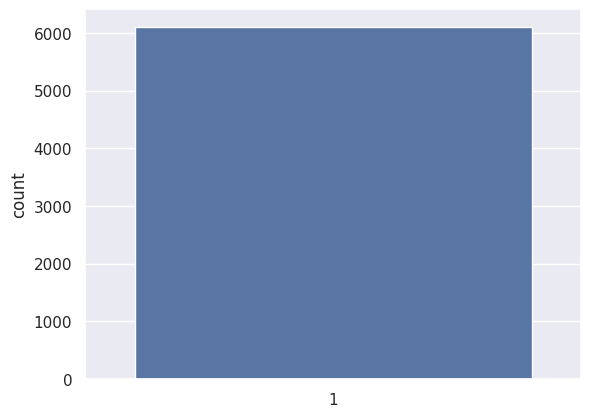

In [49]:
sns.countplot(x=homeplanet_counts)

Okay, so every member of a certain group comes from the same home planet. That's great, so I can just fill it in based on the group.

In [50]:
df = fill_missing_by_group(df, "HomePlanet", "PassengerGroup")

Missing values before: 201 (2.31%)
Missing values after: 111 (1.28%)


I managed to fill out a good chunk of of missing values. I suspect that there is a correlation between surnames and home planet. 

In [51]:
# Extract the surname (everything after the last space)
df["Surname"] = df["Name"].str.extract(r"(\S+)$")

df = fill_missing_by_group(df, "HomePlanet", "Surname")

Missing values before: 111 (1.28%)
Missing values after: 12 (0.14%)


In [52]:
df = drop_missing_rows(df, "HomePlanet")

Dropped 12 rows - 0.14% of the dataset.


Dropping the remaining rows where HomePlanet is missing will only drop 0.14% of the data. That's fine, so I'll just get rid of that.

**CryoSleep**

Let's investigate missing values in CryoSleep. The best indicator is probably to check if they spent any money or not. 

In [53]:
df = fill_missing_by_group(df, "CryoSleep", "TotalMoneySpent")

Missing values before: 217 (2.50%)
Missing values after: 38 (0.44%)


Thats very strange, maybe someone used somebody elses name to bill their Spa-treatment...

CryoSleep probably correlates with PassengerGroup, it seems unlikely that only some members of the group went to sleep. 

In [54]:
df = fill_missing_by_group(df, "CryoSleep", "PassengerGroup")

Missing values before: 38 (0.44%)
Missing values after: 16 (0.18%)


Awesome, we filled about half the values. Since we already know that the different groups are going to the same planet, maybe Destination can help us too. 

In [55]:
df = fill_missing_by_group(df, "CryoSleep", "Destination")

Missing values before: 16 (0.18%)
Missing values after: 0 (0.00%)


**Cabin Number**

For the cabins, I think it makes sense to look into things like Surname and PassengerGroup.

In [56]:
df = fill_missing_by_group(df, "CabinNumber", "PassengerGroup")

Missing values before: 199 (2.29%)
Missing values after: 99 (1.14%)


In [57]:
df = fill_missing_by_group(df, "CabinNumber", "Surname")

Missing values before: 99 (1.14%)
Missing values after: 9 (0.10%)


It would be strange if only some of the people in the same cabin went to sleep, so it's probably a correlation here as well.

In [58]:
df = fill_missing_by_group(df, "CabinNumber", "CryoSleep")

Missing values before: 9 (0.10%)
Missing values after: 0 (0.00%)


Perfect - no more missing values.

**Destination**

I think that destination is likely to correlate with the differenet groups/cabins. 

In [59]:
df = fill_missing_by_group(df, "Destination", "PassengerGroup")

Missing values before: 182 (2.10%)
Missing values after: 103 (1.19%)


In [60]:
df = fill_missing_by_group(df, "Destination", "CabinNumber")

Missing values before: 103 (1.19%)
Missing values after: 3 (0.03%)


Only 3 remaining, let's do Surname as well.

In [61]:
df = fill_missing_by_group(df, "Destination", "Surname")

Missing values before: 3 (0.03%)
Missing values after: 0 (0.00%)


Beautiful, no more missing data.

**VIP**

Only a very small proportion of the passengers travelled as VIPs. I think it's likely that passengers in the same group had the same VIP status. 

In [62]:
df = fill_missing_by_group(df, "VIP", "PassengerGroup")

Missing values before: 203 (2.34%)
Missing values after: 116 (1.34%)


Again, we got rid of a fair bit of them. The cabins are probably different based on VIP status, so I'll try to apply that theory as well.

In [63]:
df = fill_missing_by_group(df, "VIP", "CabinNumber")

Missing values before: 116 (1.34%)
Missing values after: 4 (0.05%)


Still a few left. It would be mean if only some members of a family had VIP-tickets.

In [64]:
df = fill_missing_by_group(df, "VIP", "Surname")

Missing values before: 4 (0.05%)
Missing values after: 0 (0.00%)


**Status Check**

In [65]:
display_missing_data_summary(df)


Overall missing value percentage: 0.65%
Percentage of data rows that would be dropped if all rows with missing values were removed: 6.50%
Missing Values Summary by Column:
          Number Missing  Percentage
Cabin                199        2.29
Age                  179        2.06
Name                 195        2.25
Deck                 199        2.29
ShipSide             199        2.29
AgeGroup             179        2.06
Surname              195        2.25


**ShipSide**

Let's investigate the missing data for the ShipSide column. Given the size of the ship, it's likely that members of the same PassengerGroup would be staying on the same side.

In [66]:
df = fill_missing_by_group(df, "ShipSide", "PassengerGroup")

Missing values before: 199 (2.29%)
Missing values after: 99 (1.14%)


Half of the values gone. Maybe there is a correlation with the deck.

In [67]:
df = fill_missing_by_group(df, "ShipSide", "Deck")

Missing values before: 99 (1.14%)
Missing values after: 99 (1.14%)


That didn't help, so the different decks probably span over the whole ship. Maybe the VIP cabins are on the same side.

In [68]:
df = fill_missing_by_group(df, "ShipSide", "VIP")

Missing values before: 99 (1.14%)
Missing values after: 0 (0.00%)


Amazing, all sorted.

**Deck**

Once again, the different groups and VIPs are hopefully on the same deck of this large ship.

In [69]:
df = fill_missing_by_group(df, "Deck", "PassengerGroup")

Missing values before: 199 (2.29%)
Missing values after: 99 (1.14%)


In [70]:
df = fill_missing_by_group(df, "Deck", "VIP")

Missing values before: 99 (1.14%)
Missing values after: 0 (0.00%)


**Surname**

This one seems a bit more tricky. Hopefully the families (people who share Surname) are on the same side of the ship.

In [71]:
# Filter to include only families with more than one member to make the pattern clearer
family_sizes = df["Surname"].value_counts()
large_families = family_sizes[family_sizes > 1].index
df_large_families = df[df["Surname"].isin(large_families)]

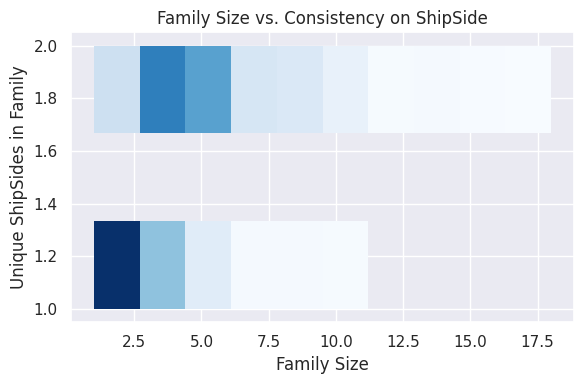

In [72]:
# Calculate the number of unique sides per family
family_side_counts = df.groupby("Surname")["ShipSide"].nunique()

# Create a DataFrame to classify families by size and consistency of ShipSide
family_data = df["Surname"].value_counts().to_frame(name="FamilySize").join(family_side_counts, on="Surname")
family_data = family_data.rename(columns={"ShipSide": "UniqueSides"})

# Plot a heatmap
plt.figure(figsize=(6, 4))
sns.histplot(data=family_data, x="FamilySize", y="UniqueSides", bins=(10, 3), cmap="Blues")
plt.title("Family Size vs. Consistency on ShipSide")
plt.xlabel("Family Size")
plt.ylabel("Unique ShipSides in Family")
plt.tight_layout()
plt.show()

Smaller families (1-5 members) tend to be on the same size of the ship. Larger families have a higher likelihood to be split across both sides of the ship. Families generally stick to the same side though.

Since we know that a lot of the families are in the same group, we can try to fill surnames using that. 

In [73]:
df = fill_missing_by_group(df, "Surname", "PassengerGroup")

Missing values before: 195 (2.25%)
Missing values after: 99 (1.14%)


If some members of the family went to sleep, there might be a likelihood that the rest did too.

In [74]:
df = fill_missing_by_group(df, "Surname", "CryoSleep")

Missing values before: 99 (1.14%)
Missing values after: 0 (0.00%)


Perfect - all surnames filled.

**Cabin**

Since we have filled the ShipSide, Deck and CabinNumber we can generate the Cabin.

The format is "Deck/CabinNumber/ShipSide".

In [75]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,PassengerGroup,PassengerNumberInGroup,Deck,ShipSide,CabinNumber,AgeGroup,GroupSize,TotalMoneySpent,SpendingCategory,Surname
1454,1539_01,Europa,0,A/17/S,55 Cancri e,32.0,0,54.0,3782.0,0.0,...,1539,1,A,S,17,30-39,1,3862.0,3001-5000,Barmant
218,0232_01,Earth,1,G/36/S,PSO J318.5-22,27.0,0,0.0,0.0,0.0,...,232,1,G,S,36,20-29,1,0.0,0-1000,Bakerrison
7866,8392_01,Earth,0,F/1610/S,PSO J318.5-22,24.0,0,86.0,669.0,1.0,...,8392,1,F,S,1610,20-29,1,756.0,0-1000,Brightez
7622,8141_01,Earth,1,G/1310/S,TRAPPIST-1e,38.0,0,0.0,0.0,0.0,...,8141,1,G,S,1310,30-39,1,0.0,0-1000,Belley
4108,4387_01,Mars,0,F/902/P,PSO J318.5-22,32.0,0,192.0,0.0,441.0,...,4387,1,F,P,902,30-39,1,651.0,0-1000,Wala
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,3130_01,Mars,0,F/588/S,TRAPPIST-1e,38.0,0,886.0,0.0,618.0,...,3130,1,F,S,588,30-39,1,1504.0,1001-3000,Frasp
7813,8339_01,Europa,0,D/246/S,TRAPPIST-1e,39.0,0,0.0,261.0,0.0,...,8339,1,D,S,246,30-39,2,3889.0,3001-5000,Dratembid
905,0978_01,Earth,0,F/203/P,TRAPPIST-1e,24.0,0,0.0,32.0,8.0,...,978,1,F,P,203,20-29,1,40.0,0-1000,Coxterez
5192,5538_01,Mars,1,F/1146/P,TRAPPIST-1e,47.0,0,0.0,0.0,0.0,...,5538,1,F,P,1146,40-49,2,0.0,0-1000,Gele


In [76]:
df["Cabin"] = df["Deck"].astype(str) + "/" + df["CabinNumber"].astype(str) + "/" + df["ShipSide"].astype(str)

In [77]:
display_missing_data_summary(df)


Overall missing value percentage: 0.27%
Percentage of data rows that would be dropped if all rows with missing values were removed: 4.27%
Missing Values Summary by Column:
          Number Missing  Percentage
Age                  179        2.06
Name                 195        2.25
AgeGroup             179        2.06


**Age**

This is probably the trickiest column to fill, and it's tempting to fill it with the median or something, but I'll try to engineer it better than that first.

In [78]:
df["Age"].describe()

count    8502.000000
mean       28.828158
std        14.492562
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64

The passengers range from 0 to 79, and the standard deeviation is 14.49. That would be considered within one standard deviation, so it's a typical range within the dataset.

It might be sensible to look at the group sizes, as large groups/families are probably traveling with children. 

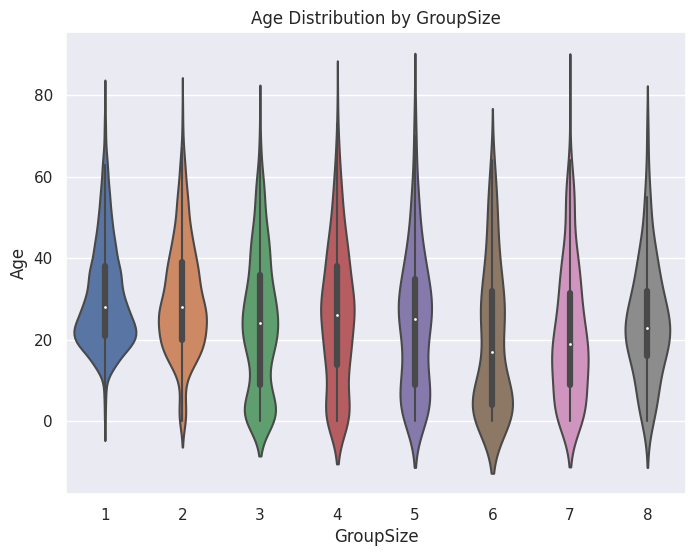

In [79]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x="GroupSize", y="Age")
plt.title("Age Distribution by GroupSize")
plt.show()

People traveling alone or in pairs have a higher density of people in their 20s, and as I suspected, the age range broadens with increasing group sizes. 

I'll fill the missing values in each group with the median in that group size. 

In [80]:
df.groupby(['GroupSize'], as_index=False)['Age'].median()

,GroupSize,Age
0,1,28.0
1,2,28.0
2,3,24.0
3,4,26.0
4,5,25.0
5,6,17.0
6,7,19.0
7,8,23.0


In [81]:
df["Age"] = df.groupby("GroupSize")["Age"].transform(lambda x: x.fillna(x.median()))

Now that the Age column is filled, I'll redo the AgeGroup calculation (I already defined the bins and labels earlier).

In [82]:
df["Age"].astype('int')

1454    32
218     27
7866    24
7622    38
4108    32
        ..
2895    38
7813    39
905     24
5192    47
235     30
Name: Age, Length: 8681, dtype: int64

In [83]:
df["AgeGroup"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels, right=True)

**Status Check**

In [84]:
display_missing_data_summary(df)


Overall missing value percentage: 0.09%
Percentage of data rows that would be dropped if all rows with missing values were removed: 2.25%
Missing Values Summary by Column:
      Number Missing  Percentage
Name             195        2.25


Everything is filled except the "Name" column, but Name isn't relevant, we can live with Surname. 

In [85]:
df = df.drop("Name", axis=1)

In [86]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CryoSleep,8681.0,0.361134,0.480357,0.0,0.0,0.0,1.0,1.0
Age,8681.0,28.78643,14.34981,0.0,20.0,27.0,37.0,79.0
VIP,8681.0,0.023384,0.15113,0.0,0.0,0.0,0.0,1.0
RoomService,8681.0,219.962101,660.798221,0.0,0.0,0.0,40.0,14327.0
FoodCourt,8681.0,448.856929,1596.798216,0.0,0.0,0.0,61.0,29813.0
ShoppingMall,8681.0,169.603963,598.317728,0.0,0.0,0.0,22.0,23492.0
Spa,8681.0,304.443958,1125.618563,0.0,0.0,0.0,53.0,22408.0
VRDeck,8681.0,297.77422,1132.495783,0.0,0.0,0.0,40.0,24133.0
Transported,8681.0,0.503629,0.500016,0.0,0.0,1.0,1.0,1.0
PassengerGroup,8681.0,4635.018431,2671.144018,1.0,2320.0,4631.0,6887.0,9280.0


In [87]:
df.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,PassengerGroup,PassengerNumberInGroup,Deck,ShipSide,CabinNumber,AgeGroup,GroupSize,TotalMoneySpent,SpendingCategory,Surname
1106,1170_01,Earth,0,E/83/S,TRAPPIST-1e,23.0,0,0.0,0.0,279.0,...,1170,1,E,S,83,20-29,1,791.0,0-1000,Mcneiley
357,0392_01,Earth,0,E/24/P,TRAPPIST-1e,48.0,0,0.0,111.0,0.0,...,392,1,E,P,24,40-49,1,1619.0,1001-3000,Carreralend
4681,4990_01,Europa,1,B/164/P,TRAPPIST-1e,35.0,0,0.0,0.0,0.0,...,4990,1,B,P,164,30-39,1,0.0,0-1000,Listive
4909,5235_01,Earth,0,G/844/P,TRAPPIST-1e,29.0,0,30.0,0.0,605.0,...,5235,1,G,P,844,20-29,1,908.0,0-1000,Olivasquez
8661,9241_01,Mars,0,E/595/P,TRAPPIST-1e,30.0,0,699.0,0.0,600.0,...,9241,1,E,P,595,30-39,1,1299.0,1001-3000,Fone


___
## Plots
___

Text(0.5, 1.0, 'Age Distribution by HomePlanet')

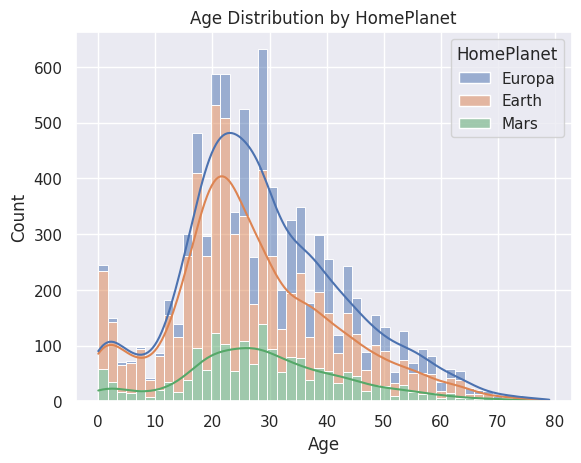

In [88]:
sns.histplot(data=df, x="Age", hue="HomePlanet", multiple="stack", kde=True)
plt.title("Age Distribution by HomePlanet")

Text(0.5, 1.0, 'CryoSleep Rate by HomePlanet')

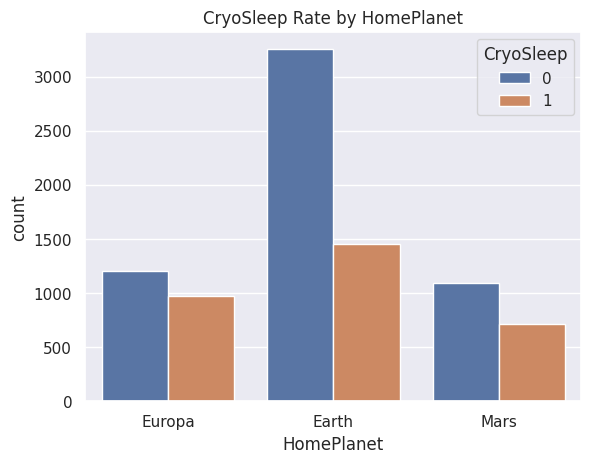

In [89]:
sns.countplot(data=df, x="HomePlanet", hue="CryoSleep")
plt.title("CryoSleep Rate by HomePlanet")


Text(0.5, 1.0, 'Distribution of Spending Categories')

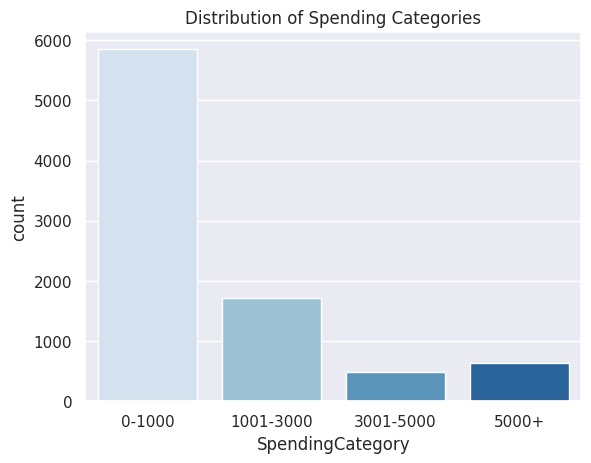

In [90]:
sns.countplot(data=df, x="SpendingCategory", palette="Blues")
plt.title("Distribution of Spending Categories")


Text(0.5, 1.0, 'Age vs Total Money Spent')

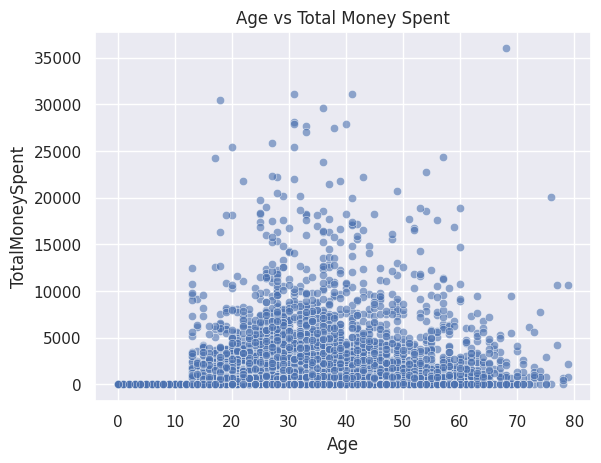

In [91]:
sns.scatterplot(data=df, x="Age", y="TotalMoneySpent", alpha=0.6)
plt.title("Age vs Total Money Spent")

Text(0.5, 1.0, 'Group Size Distribution by Destination')

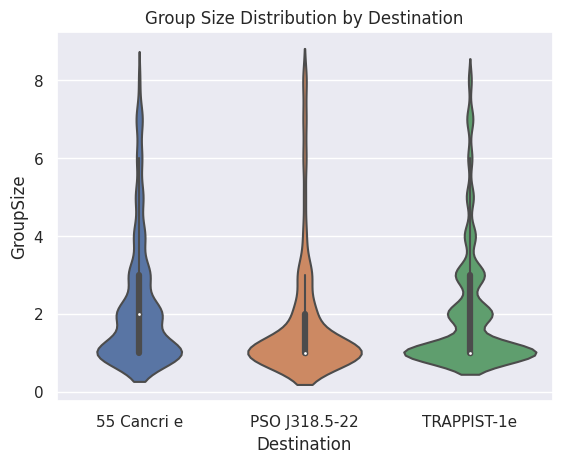

In [92]:
sns.violinplot(data=df, x="Destination", y="GroupSize", split=True)
plt.title("Group Size Distribution by Destination")


Text(0.5, 1.0, 'Age Distribution by Transported Status')

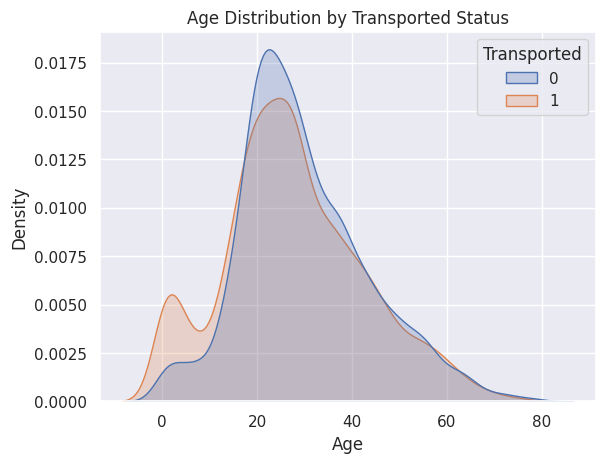

In [93]:
sns.kdeplot(data=df, x="Age", hue="Transported", fill=True)
plt.title("Age Distribution by Transported Status")

Text(0.5, 1.0, 'Distribution of Passenger Group Sizes')

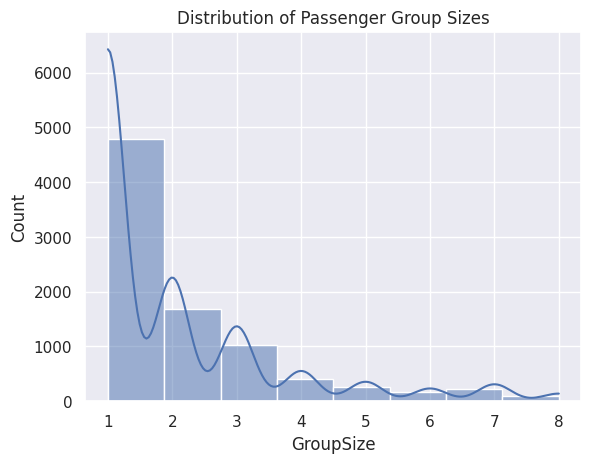

In [94]:
sns.histplot(df["GroupSize"], kde=True, bins=8)
plt.title("Distribution of Passenger Group Sizes")

Text(0.5, 1.0, 'HomePlanet vs Destination')

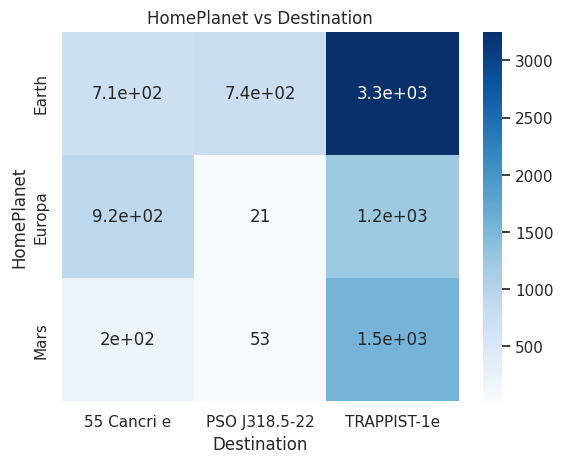

In [95]:
sns.heatmap(pd.crosstab(df["HomePlanet"], df["Destination"]), annot=True, cmap="Blues")
plt.title("HomePlanet vs Destination")

Text(0.5, 1.0, 'Proportion of Transported by HomePlanet')

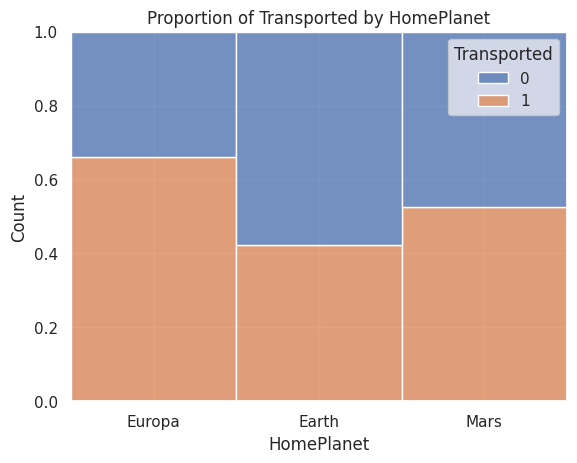

In [96]:
sns.histplot(data=df, x="HomePlanet", hue="Transported", multiple="fill")
plt.title("Proportion of Transported by HomePlanet")

___
## Preprocessing
___

In [124]:
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [106]:
X = df.drop(columns=["Transported", "PassengerId"])
y = df["Transported"].astype(int)

In [107]:
cat_features = X.select_dtypes(include=["object"]).columns
num_features = X.select_dtypes(include=["float64", "int64"]).columns

In [108]:
# Preprocessing for numerical data: scaling and filling missing values
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

In [109]:
# Preprocessing for categorical data: one-hot encoding and filling missing values
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])


In [110]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ])

___
## Model Pipeline

In [111]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [113]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_depth": [10, 20, None],
    "classifier__min_samples_split": [2, 5, 10],
}

In [114]:
# Using GridSearchCV to find the best model
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'PassengerGroup', 'PassengerNumberInGroup',
       'GroupSize', 'TotalMoneySpent'],...
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['HomePlanet', 'Cabin', 'Destination', 'ShipSide', 'CabinNumber',
       'Surname'],
      dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [10, 20, None],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [115]:
# Get the best model
best_model = grid_search.best_estimator_

In [116]:
# Evaluate the model on test set
y_pred = best_model.predict(X_test)
print("Best model accuracy on test set:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best model accuracy on test set: 0.7858376511226253
              precision    recall  f1-score   support

           0       0.76      0.83      0.80       873
           1       0.81      0.74      0.78       864

    accuracy                           0.79      1737
   macro avg       0.79      0.79      0.79      1737
weighted avg       0.79      0.79      0.79      1737



In [130]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define a new pipeline using XGBClassifier
pipeline_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(use_label_encoder=False, eval_metric="logloss"))
])

# New parameter grid for XGBoost
param_grid_xgb = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [3, 5, 7],
    "classifier__learning_rate": [0.01, 0.1, 0.2],
    "classifier__subsample": [0.7, 0.8, 1.0],
    "classifier__colsample_bytree": [0.7, 0.8, 1.0]
}

# Run GridSearchCV with XGBoost
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring="accuracy", n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Get the best model
best_xgb_model = grid_search_xgb.best_estimator_

# Evaluate the best XGBoost model
y_pred_xgb = best_xgb_model.predict(X_test)
print("Best XGBoost model accuracy on test set:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

Best XGBoost model accuracy on test set: 0.8042602187679908
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       873
           1       0.80      0.81      0.80       864

    accuracy                           0.80      1737
   macro avg       0.80      0.80      0.80      1737
weighted avg       0.80      0.80      0.80      1737



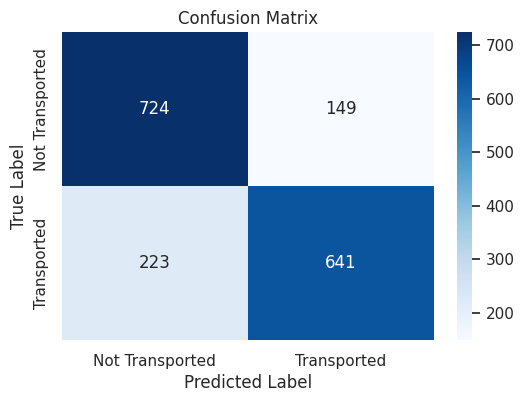

In [127]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Transported", "Transported"], yticklabels=["Not Transported", "Transported"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

___
## Save Submission
___

In [131]:
# Predict on the entire dataset for submission
df["Transported"] = best_xgb_model.predict(X)

df["Transported"] = df["Transported"].astype(bool)
submission = df[["PassengerId", "Transported"]]

submission.to_csv("submission.csv", index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv
